In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Project/

Mounted at /content/drive
/content/drive/MyDrive/Project


In [ ]:
# load best model
load_model = False

# 1. 데이터셋 불러오기
데이터셋은 torchvision 패키지에서 제공하는 STL10 dataset을 이용하겠습니다.
STL10 dataset은 10개의 label을 갖습니다.

In [ ]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy
import pandas as pd
import openpyxl

# dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from sklearn.model_selection import StratifiedShuffleSplit


In [ ]:
# specify the data path
path2data = './data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
test_all_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
train_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())
origin_ds = train_ds

Files already downloaded and verified
Files already downloaded and verified
8000
5000


In [ ]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])

train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])
###############################################################################
test_all_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in test_all_ds]
test_all_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in test_all_ds]

test_all_meanR = np.mean([m[0] for m in test_all_meanRGB])
test_all_meanG = np.mean([m[1] for m in test_all_meanRGB])
test_all_meanB = np.mean([m[2] for m in test_all_meanRGB])

test_all_stdR = np.mean([s[0] for s in test_all_stdRGB])
test_all_stdG = np.mean([s[1] for s in test_all_stdRGB])
test_all_stdB = np.mean([s[2] for s in test_all_stdRGB])
#####################################################################
print(train_meanR, train_meanG, train_meanB)
print(test_all_meanR, test_all_meanG, test_all_meanB)

0.44723064 0.4396425 0.40495726
0.4467106 0.43980986 0.40664646


In [ ]:
# define the image transformation
train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB])
])

test_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB])
])

# apply transforamtion
train_ds.transform = train_transformation
test_all_ds.transform = test_transformation
###############################################################
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=0)

indices = list(range(len(test_all_ds)))
y_test0 = [y for _, y in test_all_ds]

for val_index, test_index in sss.split(indices, y_test0):
    print('test:', test_index, 'val:', val_index)
    print(len(val_index), len(test_index))

val_ds = Subset(test_all_ds, val_index)
test_ds = Subset(test_all_ds, test_index)


###############################################################
# create DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

8000
8000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [7050 2761  227 2004]


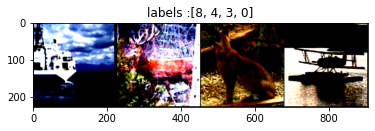

In [ ]:
# display sample images 
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels :' + str(y))

np.random.seed(6)
torch.manual_seed(1)

grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print('image indices:',rnd_inds)

x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

In [ ]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.layer1 = nn.Sequential(
            nn.Conv2d(stride=2, padding = 3, kernel_size = 7,in_channels=3,out_channels=64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        ####################################################################################
        self.layer2 = nn.Sequential(
            nn.Conv2d(stride=1, padding = 1, kernel_size = 3,in_channels=64,out_channels=64),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer2_end = nn.Sequential(
            nn.Conv2d(stride=1, padding = 1, kernel_size = 3,in_channels=64,out_channels=64),
            nn.BatchNorm2d(64)
        )
        ####################################################################################
        self.layer3_start = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(stride=2, padding = 1, kernel_size = 3,in_channels=64,out_channels=128),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(stride=1, padding = 1, kernel_size = 3,in_channels=128,out_channels=128),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.layer3_end = nn.Sequential(
            nn.Conv2d(stride=1, padding = 1, kernel_size = 3,in_channels=128,out_channels=128),
            nn.BatchNorm2d(128)
        )
        ####################################################################################
        self.layer4_start = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(stride=2, padding = 1, kernel_size = 3,in_channels=128,out_channels=256),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(stride=1, padding = 1, kernel_size = 3,in_channels=256,out_channels=256),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4_end = nn.Sequential(
            nn.Conv2d(stride=1, padding = 1, kernel_size = 3,in_channels=256,out_channels=256),
            nn.BatchNorm2d(256)
        )
        ####################################################################################
        self.layer5_start = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(stride=2, padding = 1, kernel_size = 3,in_channels=256,out_channels=512),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(stride=1, padding = 1, kernel_size = 3,in_channels=512,out_channels=512),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer5_end = nn.Sequential(
            nn.Conv2d(stride=1, padding = 1, kernel_size = 3,in_channels=512,out_channels=512),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        ####################################################################################
        self.avg = nn.AdaptiveAvgPool2d((1,1))
        self.Fc = nn.Linear(512,10)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

    def forward(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        x1 = self.layer1(x)
        
        x2 = self.layer2(x1)
        x3 = self.layer2(x2)
        x3 = x1 + x3
        x4 = self.layer2(x3)
        x5 = self.layer2_end(x4)
        x5 = x3 + x5
        
        x6 = self.layer3_start(x5)
        x7 = self.layer3(x6)
        x8 = self.layer3(x7)
        x9 = self.layer3_end(x8)
        x9 = x6+x9

        x10 = self.layer4_start(x9)
        x11 = self.layer4(x10)
        x12 = self.layer4(x11)
        x13 = self.layer4_end(x12)
        x13 = x11+x13
        
        x14 = self.layer5_start(x13)
        x15 = self.layer5(x14)
        x16 = self.layer5(x15)
        x17 = self.layer5_end(x16)
        x17 = x17 + x15
        
        x18 = self.avg(x17)
        x18 = torch.squeeze(x18)
        x19 = self.Fc(x18)
        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################
        return x19

# 2. 모델 구축하기

In [ ]:
# get learning rate 
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [ ]:
# define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# creat VGGnet object
if load_model:
    model = Resnet().to(device)
    opt = optim.Adam(model.parameters(), lr=0.001)
    checkpoint = torch.load('./models/Resnet_model.pt')
    model.load_state_dict(checkpoint['model'])
    model.to(device=device)

    loss_func = nn.CrossEntropyLoss(reduction="sum")
    opt.load_state_dict(checkpoint['optimizer'])
    current_lr = checkpoint['lr']
    best_loss = checkpoint['best_val_loss']
    exp_dir = checkpoint['exp_dir']
    print('Loading model: ', 'Resnet')
    print(model)
else :
    model = Resnet().to(device)

    loss_func = nn.CrossEntropyLoss(reduction="sum")
    opt = optim.Adam(model.parameters(), lr=0.001)
    current_lr = get_lr(opt)
    print(model)

# define learning rate scheduler
# from torch.optim.lr_scheduler import CosineAnnealingLR
# lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-5)

from torch.optim.lr_scheduler import StepLR
lr_scheduler = StepLR(opt, step_size=30, gamma=0.1)

# print model summary
summary(model, input_size=(3, 224, 224), device=device.type)

cuda
Resnet(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2_end): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3_start): Sequential(
    (0): ReLU()
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(128, 128, kernel_siz

# 3. 모델 학습하기

In [ ]:
# function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b


# function to calculate loss and metric per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b
        
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric


# function to start training
def train_test(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    test_dl=params["test_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': [],'test': []}
    metric_history = {'train': [], 'val': [],'test': []}

    # # GPU out of memoty error
    # best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
            test_loss, test_metric = loss_epoch(model, loss_func, test_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)
        loss_history['test'].append(test_loss)
        metric_history['test'].append(test_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            print('new best loss')
            torch.save(
                {
                    'epoch': epoch,
                    'model': model.state_dict(),
                    'optimizer': opt.state_dict(),
                    'best_val_loss': best_loss,
                    'lr': current_lr,
                    'exp_dir': './models/'
                },
                f='./models/Resnet_model.pt'
            )

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f,test loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss,val_loss, test_loss, 100*test_metric, (time.time()-start_time)/60))
        print('-'*10)
        

    # model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [ ]:
# definc the training parameters
params_train = {
    'num_epochs':50,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'test_dl':test_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
model, loss_hist, metric_hist = train_test(model, params_train)

Epoch 0/4, current lr=0.001
new best loss


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


train loss: 1.865706, val loss: 1.793024, accuracy: 29.30, time: 1.6146 min
----------
Epoch 1/4, current lr=0.001
train loss: 1.657882, val loss: 2.350149, accuracy: 21.28, time: 3.2043 min
----------
Epoch 2/4, current lr=0.001
new best loss
train loss: 1.519455, val loss: 1.605625, accuracy: 41.26, time: 4.8587 min
----------
Epoch 3/4, current lr=0.001
train loss: 1.406651, val loss: 1.728206, accuracy: 39.06, time: 6.4831 min
----------
Epoch 4/4, current lr=0.001
train loss: 1.292610, val loss: 1.773176, accuracy: 38.12, time: 8.0960 min
----------


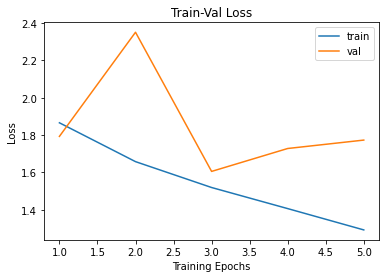

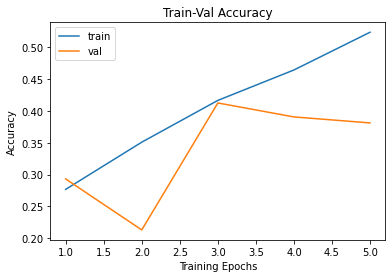

In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]
train_loss_hist = loss_hist["train"]
val_loss_hist = loss_hist["val"]
test_loss_hist = loss_hist["test"]
train_acc_hist = metric_hist["train"]
val_acc_hist = metric_hist["val"]
test_acc_hist = metric_hist["test"]

# convert list to dataframe and save to excel
df = pd.DataFrame([train_loss_hist, val_loss_hist, test_loss_hist, train_acc_hist, val_acc_hist, test_loss_hist],
                  index=['train_loss','val_loss','test_loss','train_accuracy','val_accuracy','test_accuracy'], columns=range(0,num_epochs))
path2df = './graph'
if not os.path.exists(path2df):
    os.mkdir(path2df)
df.to_excel('./graph/ResNet.xlsx', sheet_name='ResNet')

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.plot(range(1,num_epochs+1),loss_hist["test"],label="test")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.plot(range(1,num_epochs+1),metric_hist["test"],label="test")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10])


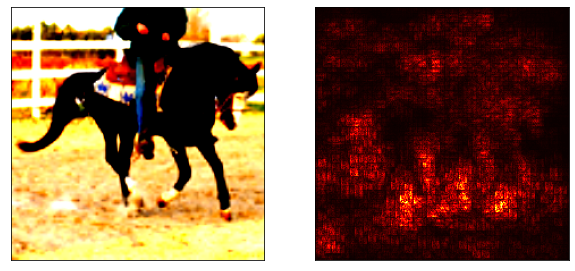

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10])


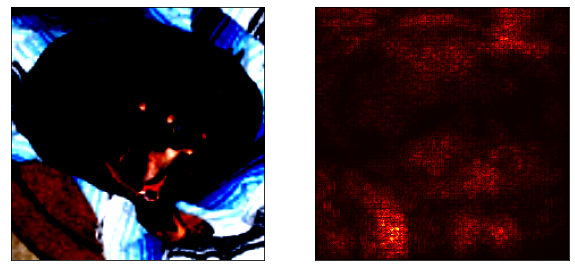

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10])


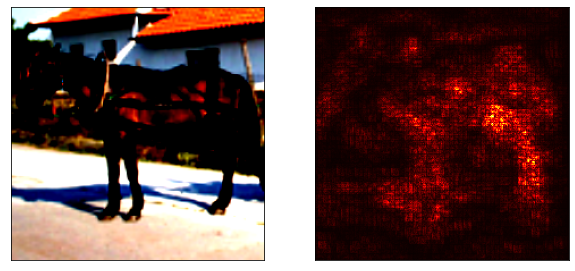

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10])


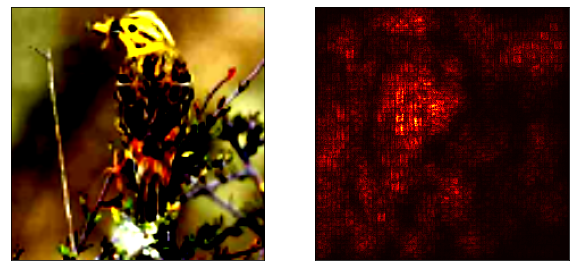

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10])


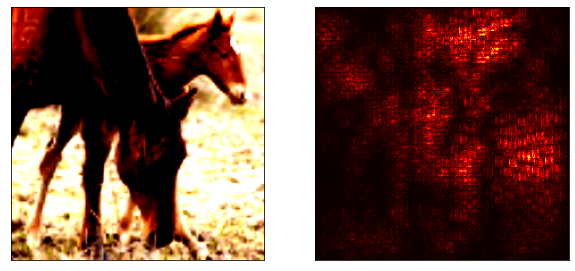

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10])


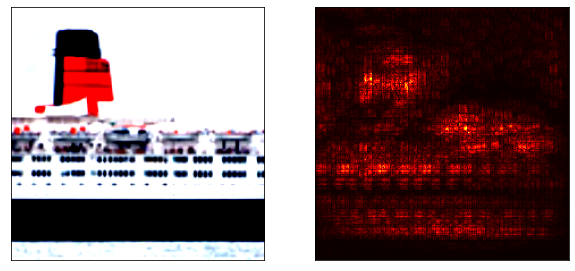

In [ ]:
def saliency(input, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    print(preds.shape)
    score, indices = torch.max(preds, 0)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = input[0]
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(input_img.detach().cpu().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.cpu().numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

from PIL import Image

input1 = train_ds[0][0].to(device)
saliency(input1, model)

input2 = train_ds[15][0].to(device)
saliency(input2, model)

input3 = train_ds[25][0].to(device)
saliency(input3, model)

input4 = test_ds[0][0].to(device)
saliency(input4, model)

input5 = test_ds[15][0].to(device)
saliency(input5, model)

input6 = test_ds[25][0].to(device)
saliency(input6, model)